In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from collections import Counter
import tensorflow as tf
import keras
from tensorflow.keras import layers

In [2]:
f = h5py.File('mouse1sample1.hdf5','r')

In [3]:
# Generate 
genes = set()
annotated_cells = []
annotations = []

for cell_id in f['cells']:
    cell = f['cells'][cell_id]
    ann = dict(cell.attrs)['annotation']
    if ann != 'unannotated':
        annotated_cells.append(cell_id)
        annotations.append(ann)
    for z in cell.attrs['zslices']:
        spot_genes = cell['spot_genes'][z]
        genes.update(set(spot_genes))
annotations_count = Counter(annotations)

Number of Annotated Samples: 18453
Num of Cell Types: 93
Max Number of Samples per Cell Type: 2136
Min Number of Samples per Cell Type: 1
Average Number of Samples per Cell Type: 198.41935483870967


<BarContainer object of 93 artists>

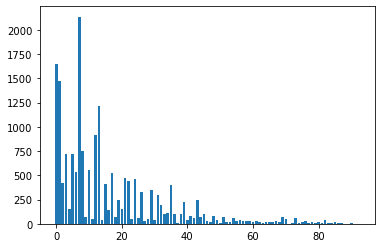

In [4]:
print("Number of Annotated Samples:", len(annotated_cells))
print("Num of Cell Types:", len(annotations_count))
print("Max Number of Samples per Cell Type:", max(annotations_count.values()))
print("Min Number of Samples per Cell Type:", min(annotations_count.values()))
print("Average Number of Samples per Cell Type:", sum(annotations_count.values())/93)

#graph of num of samples across cell-types 
plt.bar(np.arange(0,93), annotations_count.values())

In [43]:
# Long processing step to extract coordinates and genes, run only once

maxlen = 1682
data_coords = []
data_genes = []
gene_indices = {k: v for v, k in enumerate(set(genes))}

for cell_id in annotated_cells:
    cell_coords = []
    cell_genes = []
    cell = f['cells'][cell_id]
    keys = list(cell['boundaries'].keys())
    
    for z in cell.attrs['zslices']:   
        spot_coords = cell['spot_coords'][z]
        spot_genes = cell['spot_genes'][z]
        
        cell_coords += list(spot_coords)
        cell_genes += [gene_indices[gene] for gene in list(spot_genes)]
        
    z = keys[int(len(keys)/2)]
    boundary = cell['boundaries'][z]
     
    cell_coords += list(boundary)
    cell_genes += [-1] * len(boundary)
    
    data_coords.append(cell_coords)
    data_genes.append(cell_genes)


data_coords = keras.preprocessing.sequence.pad_sequences(np.array(data_coords), maxlen = maxlen)
data_genes = np.expand_dims(keras.preprocessing.sequence.pad_sequences(np.array(data_genes), maxlen=maxlen), axis=-1)

data = np.concatenate([data_coords, data_genes], axis=-1)
print(data.shape)
np.save('data.npy', data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(18453, 1682, 3)


In [137]:
with open('data.npy', 'rb') as f:
    data = np.load(f)
print(data.shape)

(18453, 1682, 3)


In [44]:
# creating one-hot coded vectors for cell-type (labels for multi)
annotation_indices = {k: v for v, k in enumerate(list(annotations_count.keys()))}
labels = np.zeros((len(annotated_cells), len(annotation_indices)))
for index in range(len(annotated_cells)):
    cell = f['cells'][annotated_cells[index]]
    ann = dict(cell.attrs)['annotation']
    arr_index = annotation_indices[ann]
    labels[index][arr_index] = 1

In [22]:
maxlen = 0
for ex in data:
    if len(ex[1]) > maxlen:
        maxlen = len(ex[1])
print(maxlen)       

1682


In [139]:
from sklearn.model_selection import train_test_split

train, test, train_y, test_y = train_test_split(data, labels, test_size=0.3)
test, val, test_y, val_y = train_test_split(test, test_y, test_size=0.5)

val = keras.preprocessing.sequence.pad_sequences(val, maxlen=maxlen)
test = keras.preprocessing.sequence.pad_sequences(test, maxlen=maxlen)

print(train.shape, train_y.shape)
print(val.shape, val_y.shape)
print(test.shape, test_y.shape)

(12917, 1682, 3) (12917, 93)
(2768, 1682, 3) (2768, 93)
(2768, 1682, 3) (2768, 93)


In [72]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [125]:
class GeneAndPositionEmbedding(layers.Layer):
    def __init__(self, coord_size, vocab_size, embed_dim):
        super(GeneAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.x_emb = layers.Embedding(input_dim=coord_size, output_dim=embed_dim)
        self.y_emb = layers.Embedding(input_dim=coord_size, output_dim=embed_dim)

    def call(self, x):
        xcoord = self.x_emb(x[:,:,0])
        ycoord = self.y_emb(x[:,:,1])
        genes = self.token_emb(x[:,:,-1])
        return xcoord + ycoord + genes

In [138]:
# Temporary code to get coord_size for use in the embedding layer (found to be 10880)

# min = 0
# max = 0

# for point in data:
#     for coord in point:
#         if coord[0] > max:
#             max = coord[0]
#         if coord[0] < min:
#             min = coord[0]
            
#         if coord[1] > max:
#             max = coord[1]
#         if coord[1] < min:
#             min = coord[1]
    
# print(min)
# print(max)
# print(max - min)

In [132]:
embed_dim = 32  # Embedding size for each token
num_heads = 3  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
vocab_size = len(genes) + 1
coord_size = 10880

inputs = layers.Input(shape=(maxlen,3))
embedding_layer = GeneAndPositionEmbedding(coord_size, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(93, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [133]:
#TODO: Prevent overfitting, experiment with learning rate
# lr= tf.keras.optimizers.schedules.ExponentialDecay(
#     0.0001,
#     decay_steps=100000,
#     decay_rate=0.95,
#     staircase=True)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    train, train_y, batch_size=32, epochs=10, validation_data=(val, val_y)
)

Epoch 1/10
404/404 [==============================] - 123s 301ms/step - loss: 3.0467 - accuracy: 0.2593 - val_loss: 1.6231 - val_accuracy: 0.6022
Epoch 2/10
404/404 [==============================] - 121s 300ms/step - loss: 1.3710 - accuracy: 0.6458 - val_loss: 1.1203 - val_accuracy: 0.6998
Epoch 3/10
404/404 [==============================] - 121s 301ms/step - loss: 1.0022 - accuracy: 0.7263 - val_loss: 1.0474 - val_accuracy: 0.7124
Epoch 4/10
404/404 [==============================] - 120s 298ms/step - loss: 0.8124 - accuracy: 0.7667 - val_loss: 1.0378 - val_accuracy: 0.7222
Epoch 5/10
404/404 [==============================] - 120s 297ms/step - loss: 0.6981 - accuracy: 0.7959 - val_loss: 1.0600 - val_accuracy: 0.7207
Epoch 6/10
404/404 [==============================] - 121s 298ms/step - loss: 0.6000 - accuracy: 0.8236 - val_loss: 1.0630 - val_accuracy: 0.7399
Epoch 7/10
404/404 [==============================] - 120s 298ms/step - loss: 0.5341 - accuracy: 0.8382 - val_loss: 1.0760 -

In [141]:
model.evaluate(test, test_y)

87/87 [==============================] - 10s 111ms/step - loss: 0.5033 - accuracy: 0.8689


[0.5032734274864197, 0.8688583970069885]